# Entendimiento de los datos RaSa

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_22_202415'
db_psswd = 'Estudiante_201117125'

PATH='./'

### Información dada por la organización relacionada con los datos
RaSA de forma conjunta con un grupo de consultores de inteligencia de negocios, ha trabajado en una especificación de los primeros análisis que quiere que usted realice. En esta primera fase, a partir de estos análisis propuestos, la empresa le ha entregado una serie de fuentes de datos y requiere que usted realice los siguientes entregables relacionados con la etapa de entendimiento de datos:

Dichos datos pueden tener errores ya que no han sido utilizados previamente para ser analizados. La empresa nos da información adicional sobre los datos:

- Las áreas de servicios reportadas cubren todos los condados del país
- Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.
- Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019
- La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.
- El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100.
- Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018.
- Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [30]:
sql_fuentes = 'FuenteCondicionesDePago_Copia_E'

In [31]:
#Se cargan los dataframes desde la base de datos
fuentes = obtener_dataframe_de_bd(db_connection_string, sql_fuentes, db_user, db_psswd)

### Entendimiento general de datos "Fuente Condiciones de Pago"

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [32]:
fuentes.show(31)

+---------------------+--------------------+-------------+
|IdCondicionesDePago_T|         Descripcion|         Tipo|
+---------------------+--------------------+-------------+
|                  187|Copay with deduct...|       Copago|
|                  204|       Copay per Day|       Copago|
|                   45|         Coinsurance|     Coseguro|
|                   85|Copay per Day bef...|       Copago|
|                   18|No Charge after d...|     Coseguro|
|                  136|Copay per Stay wi...|       Copago|
|                   27|Coinsurance after...|     Coseguro|
|                  238|               Copay|       Copago|
|                  207|No Charge after d...|       Copago|
|                  153|Copay after deduc...|       Copago|
|                   36|      Not Applicable|     Coseguro|
|                   17|Copay per Day aft...|       Copago|
|                  119|Copay per Day wit...|       Copago|
|                  170|Copay before dedu...|       Copag

Como puede observar en la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. La información del cliente es su identificador <i>ID_de_cliente</i>, el identificador de la persona que eligió la órden <i>eleccionado_por_ID_de_persona</i>, el identificador de la persona de contacto <i>ID_de_persona_de_contacto</i>, el <i>Número_de_pedido_de_compra_del_cliente</i>. La información del empleado es su identificador <i>ID_de_vendedor</i>. La información de la órden es: el identificador de la órden <i>ID_de_pedido</i>, el identificador que indica si es un pedido pendiente <i>ID_de_pedido_pendiente</i>, la fecha en la que se realizó el pedido <i>Fecha_de_pedido</i>, la fecha de entrega esperada del pedido <i>Fecha_de_entrega_esperada</i> y <i>Pedido_pendiente_de_suministro_insuficiente</i> que indica si es un pedido pendiente o no.
El esquema de un DataFrame incluye los nombres de las columnas asi como el tipo de dato. Recuerde que tipo de dato (e.g., booleano, caracteres, enteros, flotantes, colecciones) es diferente a tipo de variable (numérica y categórica).

In [33]:
fuentes.schema

StructType(List(StructField(IdCondicionesDePago_T,IntegerType,true),StructField(Descripcion,StringType,true),StructField(Tipo,StringType,true)))

Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**. Del pedido se tiene el identificador del detalle <i>Detalle_orden_ID</i>, el identificador de la orden a la que está relacionado cada detalle <i>ID_de_pedido</i>, la <i>Cantidad_seleccionada</i> del producto para la orden, la fecha de selección <i>Seleccion_completada_cuando</i>. Del producto tenemos el <i>ID_Producto</i>, su <i>Descripcion</i>, el tipo de paquete <i>ID_Tipo_Paquete</i> (Ej. 1.Bolsa, 4. Caja), la <i>Cantidad</i>, el <i>Precio_unitario</i>, y la <i>Tasa_impuesto</i> asociada a ese producto. Una primera aclaración a solicitar por parte del negocio es cuál es la diferencia entre cantidad y cantidad seleccionada

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [34]:
print((fuentes.count(), len(fuentes.columns)))

(31, 3)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 31 tipos de Fuentes de Condiciones de Pago en un total de 3 variables a revisar de las cuales 1 es un ID que identifica el tipo de condición de pago y 2 variables string que relacionan los tipos de pago (copagos y coseguros).

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que existen 15 tipos de copago y 5 de coseguro

In [35]:
descripcion = fuentes.select("Tipo", "Descripcion").groupBy("Tipo").count()
descripcion.show()

+-------------+-----+
|         Tipo|count|
+-------------+-----+
|     Copagado|    1|
|  Coseguridad|    1|
|       Copago|   19|
|SinTipoCopago|    1|
|          NaN|    2|
|     Coseguro|    7|
+-------------+-----+



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Copago"***. Encontramos 14 diferentes categorias, pero en la tabla general encontramos el tipo Copagado podría considerarse dentro de "Copago". Haciendo este ajuste en el select encontramos que solo existen 14 descripciones de este tipo. Existen dos descripciones ***No Charge after d*** y ***No Charge*** que pueden referirse al tipo Coseguro y que están incorrectamente asignadas

In [38]:
fuentes.select("Descripcion").where(fuentes["Tipo"].isin("Copago", "pago")).distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|      Copay per Stay|
|No Charge after d...|
|           No Charge|
|Copay before dedu...|
|Copay per Stay wi...|
|Copay per Stay af...|
|Copay per Day aft...|
|Copay with deduct...|
|Copay after deduc...|
|Copay per Day bef...|
|Copay per Stay be...|
|Copay per Day wit...|
|               Copay|
|       Copay per Day|
+--------------------+



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Coseguro"***. Encontramos 4 diferentes categorias. Exite una categoria en el tipo Copago llamada ***No Charge*** que puede referirse al 5 grupo de copago

In [39]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="Coseguro").distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|No Charge after d...|
|Coinsurance after...|
|         Coinsurance|
|      Not Applicable|
+--------------------+



In [43]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="NaN").distinct().show()
fuentes.select("IdCondicionesDePago_T").where(fuentes["Tipo"]=="NaN").distinct().show()

+--------------+
|   Descripcion|
+--------------+
|Copay per Stay|
+--------------+

+---------------------+
|IdCondicionesDePago_T|
+---------------------+
|                  221|
+---------------------+



Existe un caso de tipo Nan que corresponde a la descripción ***Copay per Stay*** con ID de condiciones ***221***. Este caso puede ser planteado al cliente para indagar si se trata de un error y corresponde a la categoria Copago - lo que podrian completar las 15 condiciones expuestas por el cliente

Como resultado de la comprobación de la regla de negocio: ***Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente*** se encuentra que existen diferencias entre lo reportado por el negocio y lo entregado en la tabla. En Copagos se podrían considerar 14 tipos y en Coseguros se encuentran 4 tipos, aunque puede tratarse de un error de asignación de categorias y no de faltantes en la base de datos

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [44]:
fuentes.summary().show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    25%|                   45|          null|          NaN|
|    50%|                  119|          null|          NaN|
|    75%|                  204|          null|          NaN|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



In [54]:
fuentes.groupBy('Descripcion').pivot('Tipo').count().show()

+--------------------+--------+------+-----------+--------+----+-------------+
|         Descripcion|Copagado|Copago|Coseguridad|Coseguro| NaN|SinTipoCopago|
+--------------------+--------+------+-----------+--------+----+-------------+
|      Copay per Stay|    null|     1|       null|    null|   2|         null|
|No Charge after d...|    null|     2|       null|       1|null|         null|
|Coinsurance after...|    null|  null|       null|       2|null|         null|
|           No Charge|    null|     2|          1|    null|null|         null|
|Copay before dedu...|    null|     1|       null|    null|null|         null|
|Copay per Stay wi...|    null|     1|       null|    null|null|         null|
|Copay per Stay af...|    null|     2|       null|    null|null|            1|
|Copay per Day aft...|    null|     1|       null|    null|null|         null|
|Copay with deduct...|    null|     1|       null|    null|null|         null|
|         Coinsurance|    null|  null|       null|  

En las estadísticas anteriores ve

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

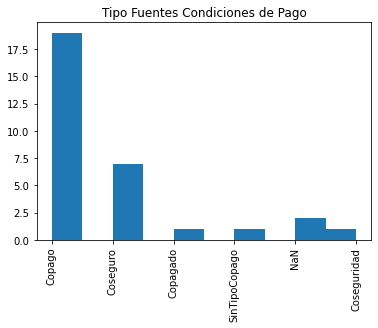

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Tipo Fuentes Condiciones de Pago')
ax1.hist(np.array(fuentes.select('Tipo').collect()))
plt.xticks(rotation=90)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [50]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios_1 = df.filter(df[c].isNull()).count()
        vacios_2 = df.filter(df[c] == "NaN").count()
        vacios = vacios_1 + vacios_2
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [52]:
columnas_vacias_ordenes = contar_vacios(fuentes)

número de vacíos para columna Tipo: 2


In [53]:
columnas_alta_cardinalidad = cardinalidad(fuentes)

Como podemos observar para las ordenes las columnas Tipo tiene 2 vacios, definidos como NaN 
Respecto a cardinalidad, Ninguna columna tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [34]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(44359, 28956)

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

### Entendimiento general de datos "Fuente Condiciones de Pago"

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [59]:
sql_areas = 'FuenteAreasDeServicio_Copia_E'

In [61]:
#Se cargan los dataframes desde la base de datos
areas = obtener_dataframe_de_bd(db_connection_string, sql_areas, db_user, db_psswd)

### Entendimiento general de datos "Fuente Condiciones de Pago"

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [62]:
areas.show(5)

+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct| Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|         100622017|New Jersey - Medi...|        34005|Burlington County|New Jersey|    464269.0|805.0|   577.0| 2017|
|         101012018|New Jersey - Medi...|        34031|   Passaic County|New Jersey|    518117.0|185.0|  2801.0| 2018|
|          10132017|BlueOptions16842F...|        12031|     Duval County|   Florida|    999935.0|774.0|  1292.0| 2017|
|         101982018|New Jersey - Medi...|        34003|    Bergen County|New Jersey|    953819.0|234.0|  4076.0| 2018|
|         102012017|New Jersey - Medi...|        34021|    Mercer County|New Jersey|    385898.0|226.0|  1708.0| 2017|
+------------------+--------------------+-------

Como puede observar 

In [63]:
areas.schema

StructType(List(StructField(IdAreaDeServicio_T,IntegerType,true),StructField(NombreAreaDeServicio,StringType,true),StructField(IdGeografia_T,IntegerType,true),StructField(Condado,StringType,true),StructField(Estado,StringType,true),StructField(PoblacionAct,DoubleType,true),StructField(Area,DoubleType,true),StructField(Densidad,DoubleType,true),StructField(Fecha,IntegerType,true)))

Por otra parte, en lo

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [64]:
print((areas.count(), len(areas.columns)))

(188815, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 188815 instancias de Fuentes de areas de servicio en un total de 9 variables a revisar de las cuales 1 es un ID que identifica el tipo de servicio y 8 variables que muestran información sobre la ubicación de las áreas y fechas.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que existen información desde 2017 al 2019

In [71]:
areas.agg({"Fecha": "max"}).show()
areas.agg({"Fecha": "min"}).show()

+----------+
|max(Fecha)|
+----------+
|      2018|
+----------+

+----------+
|min(Fecha)|
+----------+
|      1800|
+----------+



Se observa que el periodo de años de la tabla de Areas de Servicio está entre 1800 y 2018 - No corresponde a lo definido por el cliente

La siguiente regla asegura que las ***areas de servicio se distribuyen por todo el país***. Para este caso:

In [78]:
estados = areas.select("Estado").distinct()
num_estados = estados.count()
print(f"El número de estados donde se encuentran las áreas de servicio son: {num_estados}")
estados.show(35)

El número de estados donde se encuentran las áreas de servicio son: 35
+--------------+
|        Estado|
+--------------+
|        Hawaii|
|          Ohio|
|        Oregon|
|      Arkansas|
|         Texas|
|  North Dakota|
|  Pennsylvania|
|      Illinois|
|      Oklahoma|
|      Delaware|
|        Alaska|
|    New Mexico|
| West Virginia|
|      Missouri|
|       Georgia|
|       Montana|
|      Virginia|
|      Michigan|
|North Carolina|
|       Wyoming|
|        Kansas|
|    New Jersey|
|       Alabama|
|       Arizona|
|      Kentucky|
|     Louisiana|
|   Mississippi|
| New Hampshire|
|     Tennessee|
|       Florida|
|       Indiana|
|South Carolina|
|  South Dakota|
|     Wisconsin|
|         Maine|
+--------------+



In [79]:
condados = areas.select("Condado").distinct()
num_condados = condados.count()
print(f"El número de condados donde se encuentran las áreas de servicio son: {num_condados}")
estados.show(10)

El número de condados donde se encuentran las áreas de servicio son: 1398
+------------+
|      Estado|
+------------+
|      Hawaii|
|        Ohio|
|      Oregon|
|    Arkansas|
|       Texas|
|North Dakota|
|Pennsylvania|
|    Illinois|
|    Oklahoma|
|    Delaware|
+------------+
only showing top 10 rows



Como resultado se observa que se definen áreas de servicio solo para ***35 estados*** y ***1398*** condados

In [83]:
descripcion = areas.select("Condado", "Estado").distinct().groupBy("Condado").count()
descripcion.show()

+--------------------+-----+
|             Condado|count|
+--------------------+-----+
|         Owen County|    2|
|   Williamson County|    3|
|Lewis and Clark C...|    1|
|     Canadian County|    1|
|     McLennan County|    1|
|         Rock County|    1|
|       Unicoi County|    1|
|     Woodward County|    1|
|   Cumberland County|    8|
|      Webster County|    5|
|     Muskegon County|    1|
|    Hempstead County|    1|
|      Wexford County|    1|
|      Kingman County|    1|
|         Cole County|    1|
|      Rosebud County|    1|
|       DuPage County|    1|
|      El Paso County|    1|
|    Robertson County|    2|
|     Montcalm County|    1|
+--------------------+-----+
only showing top 20 rows



In [39]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="Coseguro").distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|No Charge after d...|
|Coinsurance after...|
|         Coinsurance|
|      Not Applicable|
+--------------------+



In [43]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="NaN").distinct().show()
fuentes.select("IdCondicionesDePago_T").where(fuentes["Tipo"]=="NaN").distinct().show()

+--------------+
|   Descripcion|
+--------------+
|Copay per Stay|
+--------------+

+---------------------+
|IdCondicionesDePago_T|
+---------------------+
|                  221|
+---------------------+



Existe un caso de tipo Nan que corresponde a la descripción ***Copay per Stay*** con ID de condiciones ***221***. Este caso puede ser planteado al cliente para indagar si se trata de un error y corresponde a la categoria Copago - lo que podrian completar las 15 condiciones expuestas por el cliente

Como resultado de la comprobación de la regla de negocio: ***Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente*** se encuentra que existen diferencias entre lo reportado por el negocio y lo entregado en la tabla. En Copagos se podrían considerar 14 tipos y en Coseguros se encuentran 4 tipos, aunque puede tratarse de un error de asignación de categorias y no de faltantes en la base de datos

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [44]:
fuentes.summary().show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    25%|                   45|          null|          NaN|
|    50%|                  119|          null|          NaN|
|    75%|                  204|          null|          NaN|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



In [54]:
fuentes.groupBy('Descripcion').pivot('Tipo').count().show()

+--------------------+--------+------+-----------+--------+----+-------------+
|         Descripcion|Copagado|Copago|Coseguridad|Coseguro| NaN|SinTipoCopago|
+--------------------+--------+------+-----------+--------+----+-------------+
|      Copay per Stay|    null|     1|       null|    null|   2|         null|
|No Charge after d...|    null|     2|       null|       1|null|         null|
|Coinsurance after...|    null|  null|       null|       2|null|         null|
|           No Charge|    null|     2|          1|    null|null|         null|
|Copay before dedu...|    null|     1|       null|    null|null|         null|
|Copay per Stay wi...|    null|     1|       null|    null|null|         null|
|Copay per Stay af...|    null|     2|       null|    null|null|            1|
|Copay per Day aft...|    null|     1|       null|    null|null|         null|
|Copay with deduct...|    null|     1|       null|    null|null|         null|
|         Coinsurance|    null|  null|       null|  

En las estadísticas anteriores ve

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

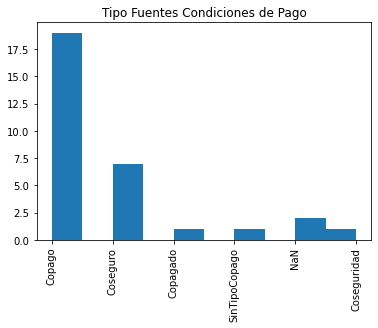

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Tipo Fuentes Condiciones de Pago')
ax1.hist(np.array(fuentes.select('Tipo').collect()))
plt.xticks(rotation=90)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [50]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios_1 = df.filter(df[c].isNull()).count()
        vacios_2 = df.filter(df[c] == "NaN").count()
        vacios = vacios_1 + vacios_2
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [52]:
columnas_vacias_ordenes = contar_vacios(fuentes)

número de vacíos para columna Tipo: 2


In [53]:
columnas_alta_cardinalidad = cardinalidad(fuentes)

### Entendimiento general de datos "Planes Beneficio"

In [84]:
sql_fuentes = 'FuentePlanesBeneficio_Copia_E'

In [86]:
#Se cargan los dataframes desde la base de datos
df_spark = obtener_dataframe_de_bd(db_connection_string, sql_fuentes, db_user, db_psswd)
df_spark.show()

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

In [114]:
df_spark.schema

StructType(List(StructField(IdTipoBeneficio_T,LongType,true),StructField(IdAreaDeServicio_T,LongType,true),StructField(IdCondicionDePagoCopago_T,IntegerType,true),StructField(IdCondicionDePagoCoseguro_T,IntegerType,true),StructField(IdNivelServicio_T,IntegerType,true),StructField(IdPlan_T,StringType,true),StructField(Fecha,StringType,true),StructField(IdProveedor_T,IntegerType,true),StructField(valorCopago,IntegerType,true),StructField(valorCoseguro,IntegerType,true),StructField(cantidadLimite,IntegerType,true)))

In [116]:
print((df_spark.count(), len(df_spark.columns)))

(36036, 11)


La tabla Planes Beneficio se compone de 11 columnas y 36036 instancias. 

In [118]:
for column in df_spark.columns:
    numero = df_spark.select(column).distinct().count()
    print(f"Número de datos distintos en columna {column} es {numero}")

Número de datos distintos en columna IdTipoBeneficio_T es 286
Número de datos distintos en columna IdAreaDeServicio_T es 6497
Número de datos distintos en columna IdCondicionDePagoCopago_T es 14
Número de datos distintos en columna IdCondicionDePagoCoseguro_T es 5
Número de datos distintos en columna IdNivelServicio_T es 3
Número de datos distintos en columna IdPlan_T es 393
Número de datos distintos en columna Fecha es 5
Número de datos distintos en columna IdProveedor_T es 125
Número de datos distintos en columna valorCopago es 49
Número de datos distintos en columna valorCoseguro es 25
Número de datos distintos en columna cantidadLimite es 42


In [88]:
print('Número de filas: {0}'.format(df_spark.count()))
print('Número de filas distintas: {0}'.format(df_spark.distinct().count()))

Número de filas: 36036
Número de filas distintas: 27543


In [89]:
df = df_spark.dropDuplicates()

In [90]:
print('COnteo: {0}'.format(df.select([c for c in df.columns if c != 'IdPlan_T']).distinct().count()))
#Como hay 27,543 filas, quiere decir que sí hay filas con ids diferentes que tienen la misma información en la fila

COnteo: 27498


In [91]:
df = df.dropDuplicates(subset = [c for c in df.columns if c != 'IdPlan_T'])

In [93]:
import pyspark.sql.functions as fn

In [94]:
df.agg(
    fn.count('IdPlan_T').alias('conteo'),
    fn.countDistinct('IdPlan_T').alias('distintos')
).show()

+------+---------+
|conteo|distintos|
+------+---------+
| 27498|      393|
+------+---------+



### Entendimiento general de datos "Fuente Tipo Beneficio"

#### Cargue de datos

In [95]:
sql_Tbeneficios = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'

In [96]:
#Se cargan los dataframes desde la base de datos
Tbeneficios = obtener_dataframe_de_bd(db_connection_string, sql_Tbeneficios, db_user, db_psswd)

### Entendimiento general de datos

In [97]:
Tbeneficios.show(5)

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|                    |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              795|Rehabilitative Sp...|Days per Benefit ...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes| 2

In [100]:
Tbeneficios.schema

StructType(List(StructField(IdTipoBeneficio_T,IntegerType,true),StructField(Nombre,StringType,true),StructField(UnidadDelLimite,StringType,true),StructField(EsEHB,StringType,true),StructField(EstaCubiertaPorSeguro,StringType,true),StructField(TieneLimiteCuantitativo,StringType,true),StructField(ExcluidoDelDesembolsoMaximoDentroDeLaRed,StringType,true),StructField(ExcluidoDelDesembolsoMaximoFueraDeLaRed,StringType,true),StructField(Fecha,IntegerType,true)))

En esta tabla se encuentra informacion escencial del cliente en cuanto a tipos de beneficio se refiere, donde encontramos informacion acerca del nombre id tipo beneficio, si se encuetra cubierta por seguros o no, si tiene limitaciones cantitativas ademas de exclusiones dentro y fuera de la red ademas del año en un formato YYYY

**IdTipoBeneficio_T**= identificacion del tipo de beneficio

**Nombre**= nombre del cliente del beneficio

**UnidadDelLimite**= cada registro representa el límite o la frecuencia con la que se puede acceder a un beneficio en un período de tiempo dado o bajo ciertas condiciones.

**EsEHB**= del inglés "EssentialHealthBenefits" si el beneficio es obligatorio por el estado o si es un beneficio esencial

**EstaCubiertaPorSeguro**= si en ese año el beneficio era obligatorio o no por el estado

**TieneLimiteCuantitativo**= Indica si se cuenta con un límite 

**ExcluidoDelDesembolsoMaximoDentroDeLaRed**= Indica Excluido del desembolso dentro de la Red

**ExcluidoDelDesembolsoMaximoFueraDeLaRed**= Indica Excluido del desembolso fuera de la Red

**Fecha**= Fecha en la que se define el tipo de beneficio

In [101]:
print((Tbeneficios.count(), len(Tbeneficios.columns)))

(849, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 849 tipos de beneficio y tenemos en total 9 variables a revisar de las cuales 2 son nùmericas y las demás son cadenas de caracteres.

## Estadísticas descriptivas por columna

In [102]:
# Verificar duplicados en 'IdTipoBeneficio_T'
duplicados_id = (
    Tbeneficios.groupBy("IdTipoBeneficio_T")
    .count()
    .filter(col("count") > 1)
)

# Verificar duplicados en 'Nombre'
duplicados_nombre = (
    Tbeneficios.groupBy("Nombre")
    .count()
    .filter(col("count") > 1)
)

# Verificar duplicados en 'Nombre'
duplicados_unidadDelLimite = (
    Tbeneficios.groupBy("UnidadDelLimite")
    .count()
    .filter(col("count") > 1)
)

# Mostrar resultados
print("Duplicados en IdTipoBeneficio_T:")
duplicados_id.show()

print("\nDuplicados en Nombre:")
duplicados_nombre.show()

print("\nDuplicados en UnidadDelLimite:")
duplicados_unidadDelLimite.show()

Duplicados en IdTipoBeneficio_T:
+-----------------+-----+
|IdTipoBeneficio_T|count|
+-----------------+-----+
|              540|    5|
|               85|   13|
|              580|    2|
|               65|    2|
|              255|    3|
|              970|    3|
|              375|    2|
|              115|    2|
|              830|   19|
|             1030|   14|
|              460|    4|
|              350|   11|
|              860|    2|
|              875|    2|
|              330|   14|
|              625|    5|
|              190|   29|
|              225|    2|
|              360|    9|
|              725|    8|
+-----------------+-----+
only showing top 20 rows


Duplicados en Nombre:
+--------------------+-----+
|              Nombre|count|
+--------------------+-----+
|Eye Refractive Su...|    2|
| Orthodontia - Adult|    6|
|Prenatal and Post...|    2|
|Human Leukocyte A...|    2|
|Outpatient Observ...|    2|
|Primary Care Visi...|    2|
|Post-cochlear imp...|    2|
|Fam

Se identica apoyado con **SQL workbench** que los id repetidos corresponden a un unico tipo de beneficio lo cual es un problema de unicidad, consistencia y validez de datos que se abordara mas adelante.

Algunos de los hallazgos encontrados en estas tablas son:

1. el id del '190'que corresponde al beneficio 'Dental Check-Up for Children' es el servicio mas usado '29'
2. UnidadDelLimite que mas frecuente Visit(s) per Year


+--------------------+---+---+
|              Column|Yes| No|
+--------------------+---+---+
|               EsEHB|430|399|
|EstaCubiertaPorSe...|743| 98|
|TieneLimiteCuanti...|271|542|
|ExcluidoDelDesemb...| 60|787|
|ExcluidoDelDesemb...|333|516|
+--------------------+---+---+



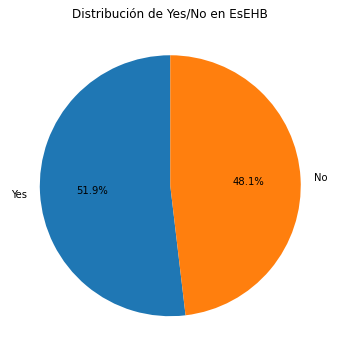

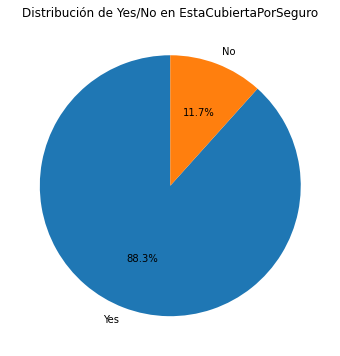

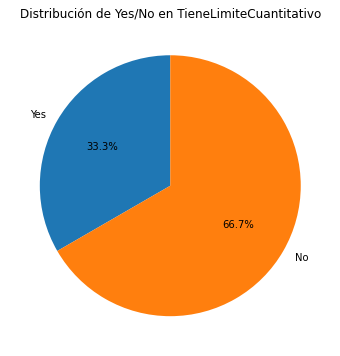

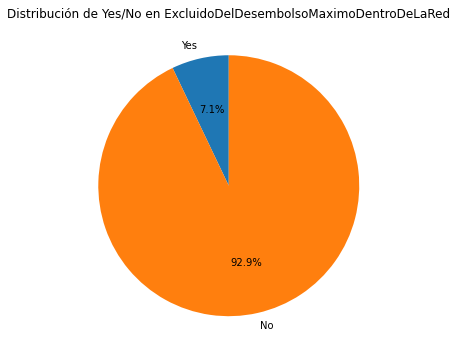

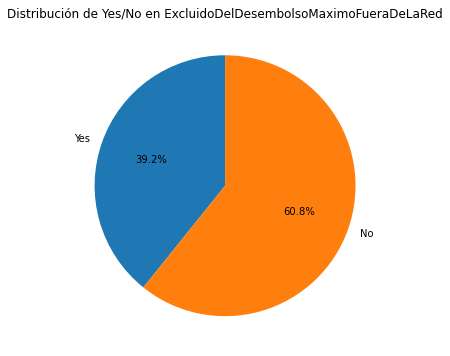

In [104]:
import pandas as pd
%matplotlib inline
columns_to_count = [
    "EsEHB", 
    "EstaCubiertaPorSeguro", 
    "TieneLimiteCuantitativo", 
    "ExcluidoDelDesembolsoMaximoDentroDeLaRed", 
    "ExcluidoDelDesembolsoMaximoFueraDeLaRed"
]

# Crear un DataFrame con las cuentas de "Yes" y "No" por cada columna
yes_no_counts = []

for col_name in columns_to_count:
    yes_count = Tbeneficios.filter(col(col_name) == "Yes").count()
    no_count = Tbeneficios.filter(col(col_name) == "No").count()
    yes_no_counts.append((col_name, yes_count, no_count))

# Convertir a un DataFrame con las columnas especificadas
yes_no_df = spark.createDataFrame(yes_no_counts, ["Column", "Yes", "No"])

# Mostrar el resultado
yes_no_df.show()

yes_no_df = pd.DataFrame(yes_no_counts, columns=["Column", "Yes", "No"])
for index, row in yes_no_df.iterrows():
    plt.figure(figsize=(6, 6))
    plt.pie(
        [row["Yes"], row["No"]],
        labels=["Yes", "No"],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Distribución de Yes/No en {row['Column']}")
    plt.show()

In [105]:
from pyspark.sql.functions import col, desc
fecha_con_mas_registros = (
    Tbeneficios.groupBy("Fecha")
    .count()
    .orderBy(desc("count"))
    .first()
)

# Muestra la fecha con más registros en formato int
print(f"La fecha con más registros es: {fecha_con_mas_registros['Fecha']} con {fecha_con_mas_registros['count']} registros.")

total_registros = Tbeneficios.count()
print(f"Total de registros en el DataFrame: {total_registros}")

La fecha con más registros es: 2017 con 672 registros.
Total de registros en el DataFrame: 849


Se encuentra que 0.79% de los registros corresponden al año 2017 

### Análisis de calidad de datos

La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

## UNICIDAD

Como se evidencia en las tablas generadas anteriormente no existe una buena unicidad de datos en la base de datos ya que se repite varias vaces y no se suman correatamente por errores tipograficos en los datos como por ejemplo **Visit(s) per Year** con **Visit(s) per year** lo cual evidencia una falta de limpieza en los datos en el apartado de unicidad

In [106]:
for column in Tbeneficios.columns:
    total_count = Tbeneficios.count()
    unique_count = Tbeneficios.select(column).distinct().count()
    uniqueness_percentage = (unique_count / total_count) * 100

    print(f"Columna: {column} - Valores únicos: {unique_count} - Porcentaje de unicidad: {uniqueness_percentage:.2f}%")

# Identificar duplicados en una columna específica (por ejemplo, 'ProductoID')
duplicados = Tbeneficios.groupBy("IdTipoBeneficio_T","UnidadDelLimite", "Nombre").count().filter(col("count") > 1)
duplicados_count = duplicados.count()

print(f"Número de productos duplicados: {duplicados_count}")

duplicados.show()

Columna: IdTipoBeneficio_T - Valores únicos: 178 - Porcentaje de unicidad: 20.97%
Columna: Nombre - Valores únicos: 178 - Porcentaje de unicidad: 20.97%
Columna: UnidadDelLimite - Valores únicos: 63 - Porcentaje de unicidad: 7.42%
Columna: EsEHB - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: EstaCubiertaPorSeguro - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: TieneLimiteCuantitativo - Valores únicos: 4 - Porcentaje de unicidad: 0.47%
Columna: ExcluidoDelDesembolsoMaximoDentroDeLaRed - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: ExcluidoDelDesembolsoMaximoFueraDeLaRed - Valores únicos: 2 - Porcentaje de unicidad: 0.24%
Columna: Fecha - Valores únicos: 2 - Porcentaje de unicidad: 0.24%
Número de productos duplicados: 201
+-----------------+--------------------+--------------------+-----+
|IdTipoBeneficio_T|     UnidadDelLimite|              Nombre|count|
+-----------------+--------------------+--------------------+-----+
|              125|Days 

para las columnas de tipo binario endonde se tienen valores Yes/No se es evidente el bajo % de unicidad , mientras que para las columnas como los son **IdTipoBeneficio_T**, **UnidadDelLimite** y **Nombre** se esperarian mejores valores

## COMPLETIDUD

Contar vacios

In [107]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        # Contar valores nulos y cadenas vacías
        vacios_nulos = df.filter(df[c].isNull()).count()
        vacios_cadenas = df.filter(df[c] == '').count()
        total_vacios = vacios_nulos + vacios_cadenas
        
        if total_vacios != 0:
            print(f'Número de vacíos para la columna {c}: {total_vacios} (Nulos: {vacios_nulos}, Cadenas vacías: {vacios_cadenas})')
            resultados.append(total_vacios)
    
    return resultados


def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [108]:
columnas_vacias_Tbeneficios = contar_vacios(Tbeneficios)

Número de vacíos para la columna UnidadDelLimite: 559 (Nulos: 0, Cadenas vacías: 559)


Se evidencia que para la columna UnidadDelLimite se encuentran 559 cadenas vacias 

In [109]:
columnas_alta_cardinalidad_Tbeneficios = cardinalidad(Tbeneficios)
columnas_alta_cardinalidad_Tbeneficios

{}

In [111]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, LongType, FloatType, StringType

# Función para contar valores nulos, ceros y vacíos en cada columna
def contar_nulos_ceros_vacios(df, columnas):
    for columna in columnas:
        # Contar valores nulos
        nulos = df.filter(F.col(columna).isNull()).count()
        
        # Contar valores iguales a 0 (solo si es numérico)
        data_type = df.schema[columna].dataType
        if isinstance(data_type, (IntegerType, DoubleType, LongType, FloatType)):
            ceros = df.filter(F.col(columna) == 0).count()
        else:
            ceros = 0
        
        # Contar valores vacíos (solo si es de tipo string)
        if isinstance(data_type, StringType):
            vacios = df.filter(F.col(columna) == "").count()
        else:
            vacios = 0
        
        # Imprimir resultados
        print(f"Columna: {columna} - Nulos: {nulos}, Ceros: {ceros}, Vacíos: {vacios}")

# Lista de las columnas a verificar
columnas = Tbeneficios.columns

# Contar los valores nulos, ceros y vacíos en cada columna
contar_nulos_ceros_vacios(Tbeneficios, columnas)

Columna: IdTipoBeneficio_T - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: Nombre - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: UnidadDelLimite - Nulos: 0, Ceros: 0, Vacíos: 559
Columna: EsEHB - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: EstaCubiertaPorSeguro - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: TieneLimiteCuantitativo - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: ExcluidoDelDesembolsoMaximoDentroDeLaRed - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: ExcluidoDelDesembolsoMaximoFueraDeLaRed - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: Fecha - Nulos: 0, Ceros: 0, Vacíos: 0


## validez

In [112]:
def verificar_valores(df, columnas):
    for c in columnas:
        # Filtrar y obtener los valores diferentes de 'Yes' o 'No'
        valores_invalidos = df.filter(~(col(c).isin('Yes', 'No')))
        conteo_invalidos = valores_invalidos.count()

        if conteo_invalidos > 0:
            print(f'La columna {c} tiene {conteo_invalidos} valores diferentes de "Yes" o "No":')
            # Mostrar los valores diferentes
            valores_diferentes = valores_invalidos.select(c).distinct().collect()
            for valor in valores_diferentes:
                print(f' - {valor[0]}')

# Lista de columnas a verificar
columnas_a_verificar = [
    "EsEHB",
    "EstaCubiertaPorSeguro",
    "TieneLimiteCuantitativo",
    "ExcluidoDelDesembolsoMaximoDentroDeLaRed",
    "ExcluidoDelDesembolsoMaximoFueraDeLaRed"
]

# Ejecutar la verificación
verificar_valores(Tbeneficios, columnas_a_verificar)

La columna EsEHB tiene 20 valores diferentes de "Yes" o "No":
 - True
La columna EstaCubiertaPorSeguro tiene 8 valores diferentes de "Yes" o "No":
 - False
La columna TieneLimiteCuantitativo tiene 36 valores diferentes de "Yes" o "No":
 - Nein
 - Si
La columna ExcluidoDelDesembolsoMaximoDentroDeLaRed tiene 2 valores diferentes de "Yes" o "No":
 - Algunas veces


Se evidencian algunos datos invalidos en las columnas descritas los cuales se imprimen para identificarlos y posteriormente hacer un tratamiento a estos datos

## Conclusión del entendimiento de datos 

#### Justificación de si es posible resolver los análisis basados en tableros de control propuestos

El modelo si es posible de resolver con analisis basado en tableros de control, solo si antes se hacen los ajustes a los hallazgos encontrados en las tabla ***FuentesAreasDeServicios, FuentesCondicionesDe Pago, FuentesPlanesBeneficio, FuenteTiposBeneficio*** los cuales fueron descritos anteriormente



**Conclusiones generales:**

1. En la tabla de FuentesAreasDeServicios encontramos información referente a los centros de salud y sus distribuciones en estados y condados
2. Para la tabla FuentesPlanesBeneficio solicitamos más información de la ***PK***, ya que con los datos suministrados no es posible tener un identificador único para los planes.
3. No hay una regla definida por el negocio que nos permita manejar de forma correcta los duplicados con unidad_de_limite
4. No hay claridad entre los tipos de pago definidos por el cliente y la información compartida en la tabla. Existen más categorias de las que deberian existir y las categorias de pago se combinan entre los tipos
5. Se requiere una explicación para el manejo de datos duplicados en todas las tablas para evitar pérdidas de información al procesar el ETL.

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, ya que se reportan 1398 condados y en el país existen 3144. 
2. La regla 2 no es completamente cierta, ya que en el valor límite de la tabla Planes_Beneficio existen datos nulos que sin la información correcta se considerarian como 0. 
3. La regla 3 no es completamente cierta, ya que existen datos con años mínimos de 1800 y máximos de 2018
4. La regla 4
5. La regla 5
6. La regla 6
7. La regla 7 es parcialmente cierta. Aunque se reportan 14 codiciones de copago y 4 de coseguro, existen problemas de información en la tabla que pueden afectar a las condiciones faltantes.

**Conclusiones de calidad:**

1. En TiposBeneficio existen columnas con redundacias de información - datos no homogeneos en la columna unidad_de_limite. 
2. En CondicionesDePago se observa un problema de consistencia de la información. Se reportan dos tipos de pago pero en la tabla aparecen 6. Además se encuentran categorias repetidas entre cada tipo.
3. Las tablas AreasDeServicios y PlanesBeneficio existen datos nulos, duplicación de llave primaria y datos repetidos que sin aclaración del cliente no se pueden eliminar.
4. En PlanesBeneficio las fechas no se reportan en el formato requerido.
5. En AreasDeServicios se reportan áreas negativas y condado y estado tienen combinaciones con el mismo ID. 
6. Existe el mismo condado en múltiples estados.

**Conclusiones de consultoria**

Teniendo en cuenta el requerimiento de RaSa Transaccional, consideramos que es posible llevar a cabo una solución pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad. 

Es posible integrar las diferentes fuentes para el desarrollo del modelo